## Read data

env: JAX_ENABLE_X64=True


INFO:root:Using numpy backend
INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2022-12-20 13:03:26.925389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


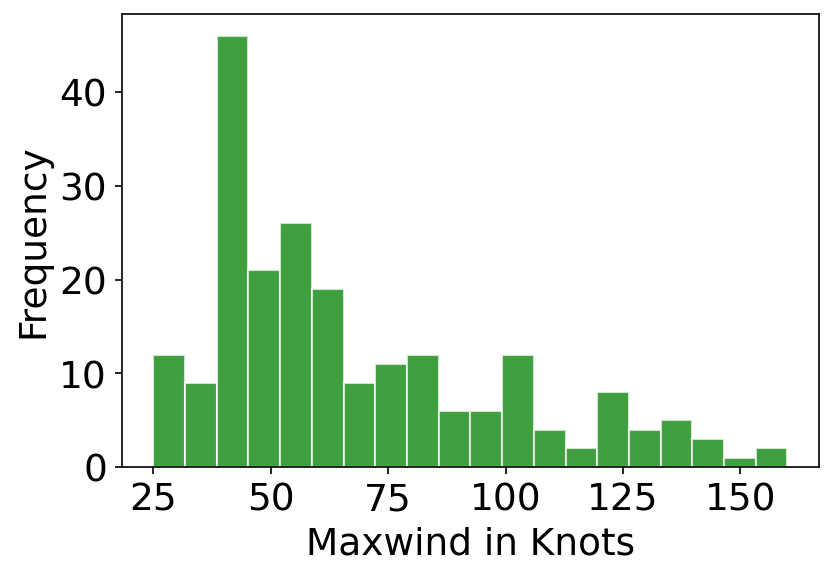

array([124,  69,  25])

In [1]:
#%env JAX_PLATFORM_NAME=cpu
%env JAX_ENABLE_X64=True

import jax
import jax.numpy as jnp
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from util import visTPCA, colors, legend_handle

# spline coeff.
data = np.load('./datasets/splines.npz')
ctrl_pts = jnp.asarray(data['cubic_CP_S2'])
wind = data['coeff_wind']

# max-wind
data = np.load('datasets/hur.npz', allow_pickle=True)
subj, seq, ids, info = data['subj'], data['seq'], data['ids'], data['info']
n_samples = np.array([int(a[-1]) for a in subj])
ids = np.repeat(np.arange(len(n_samples)), n_samples)
maxwind = jax.ops.segment_max(seq[:,5], ids, indices_are_sorted=True)

plt.figure(dpi=150)
plt.rc('font', size=18)
plt.hist(np.asarray(maxwind), 20, density=False, facecolor='g', edgecolor="w", alpha=0.75)
plt.xlabel('Maxwind in Knots')
plt.ylabel('Frequency')
# plt.title('Histogram of Maxwind')
plt.savefig('figures/hist.png')
plt.show()

# category label for classification
y = np.array([0 if w < 64 else (1 if w < 113 else 2) for w in maxwind])
#y = np.array([get_label(get_CatName(w)) for w in maxwind])
np.bincount(y)

## Run PGA

In [2]:
from morphomatics.geom import BezierSpline
from morphomatics.manifold import Sphere, CubicBezierfold, Bezierfold
from morphomatics.stats import PrincipalGeodesicAnalysis

import time
t = time.perf_counter()

S = Sphere()
M = CubicBezierfold(S, 1)

# mean-variance analysis
pga = PrincipalGeodesicAnalysis(M, ctrl_pts)

# use functional-based metric
#B = Bezierfold(S, 1, 3)
#to_coords = lambda p: B.to_coords(M.from_velocity_representation(p))
#pts = jax.vmap(to_coords)(ctrl_pts)
#pga = PrincipalGeodesicAnalysis(B, pts, mu=B.connec.mean(B, pts)[0])

print('computing PGA took %f seconds' % (time.perf_counter()-t))

computing PGA took 11.079147 seconds


## Plot scores

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


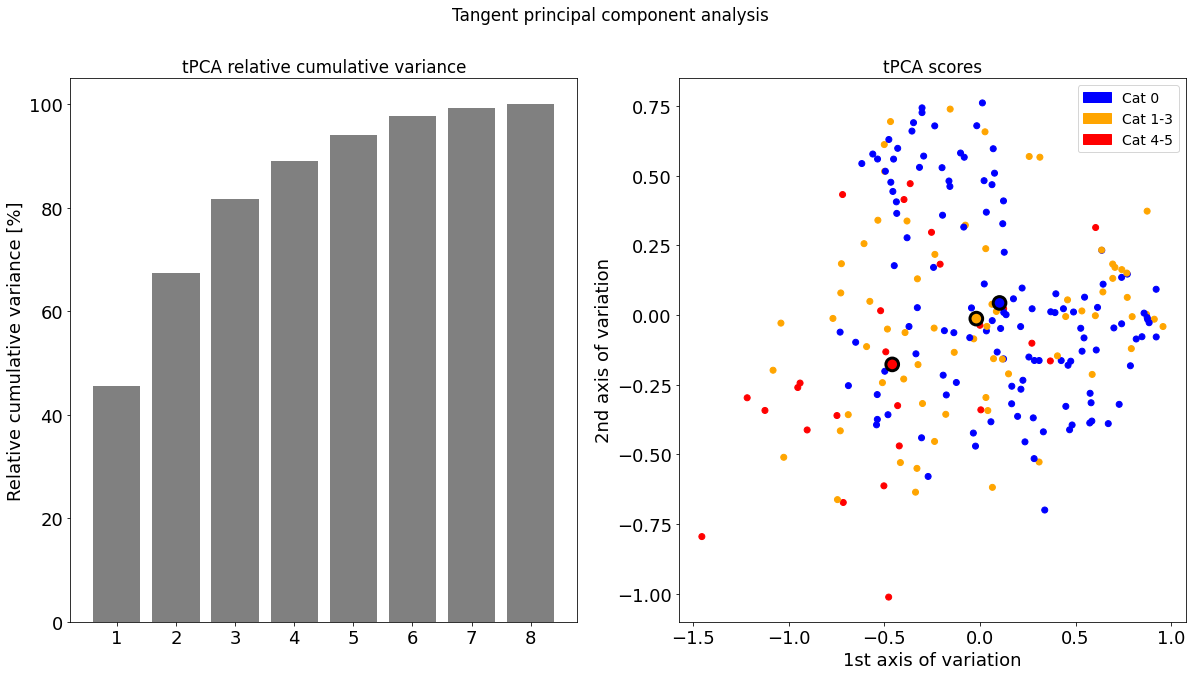

In [3]:
lbl = np.array([colors[y[i]] for i in range(len(y))])
x = pga.coeffs
cen_0 = np.mean(x[np.where(y==0)[0]], axis=0)
cen_1 = np.mean(x[np.where(y==1)[0]], axis=0)
cen_2 = np.mean(x[np.where(y==2)[0]], axis=0)
centroids = np.array([cen_0, cen_1, cen_2])
#plt.scatter(*pga.coeffs[:,:2].T, c=lbl)
#plt.show()
visTPCA(pga.variances, pga.coeffs, lbl, dim3=False, legend_handles=legend_handle, colors=colors, txt=False, centroids=centroids)

## Show splines

In [ ]:
from helpers.drawing_helpers import tube_from_spline
import pyvista as pv
pv.start_xvfb()

plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.Sphere(radius=1.))
for pts in ctrl_pts:
    B = M.from_velocity_representation(jnp.asarray(pts))
    try:
        plotter.add_mesh(tube_from_spline(B))
    except:
        pass
plotter.show(jupyter_backend='ipygany')

## Clasify

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score as bas

# k-fold stratified cross-validation
k_fold = 3
skf = StratifiedKFold(k_fold, shuffle=True)

# features
x = pga.coeffs
# x /= np.linalg.norm(x, axis=1)[:, None]

# SVM
acc = []
for n in range(1000):
    for train_index, test_index in skf.split(x, y):
        # train classifier
        svc = SVC(kernel='rbf', gamma=.7, C=3, class_weight='balanced')
        svc.fit(x[train_index], y[train_index])
        # test
        train_acc, test_acc = bas(y[train_index], svc.predict(x[train_index])), bas(y[test_index], svc.predict(x[test_index]))
        acc += [test_acc] # / k_fold # skf.get_n_splits()

acc = np.array(acc)
print('Average Test Acc: {:.5f}({:.5f})'.format(acc.mean(), acc.std()))

# np.save('figures/acc_func-based.npy', acc)